# Problem 2 - Transfer learning: Shallow learning vs Finetuning, Pytorch

## 2.1

### 2.1 (a)

In [ ]:
import tarfile
import os
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from collections import Counter
import pandas as pd
import torch.optim as optim
from torch.optim import lr_scheduler

# Path to the .tar file
tar_path = 'vgg-flowers.tar'

# Extract the .tar file
if not os.path.exists('vgg-flowers'):
    with tarfile.open(tar_path) as tar:
        tar.extractall()
    print("Dataset extracted.")
else:
    print("Dataset directory already exists.")

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the training data from folder
train_data = datasets.ImageFolder(root='vgg-flowers/train', transform=transform)

# Load the validation data from folder
val_data = datasets.ImageFolder(root='vgg-flowers/val', transform=transform)


# Create a DataLoader for training
dataloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)


# Create a DataLoader for validation
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)


# Get the class names and counts
class_names = train_data.classes
num_classes = len(class_names)
class_counts = Counter([train_data.targets[i] for i in range(len(train_data))])

# Create a DataFrame from the class distribution
class_distribution_df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Image Count'])
class_distribution_df.index = [class_names[i] for i in class_distribution_df.index]  # Replace index with actual class names
class_distribution_df.sort_index(inplace=True)  # Sort by class names

# Get the class names and counts
class_names_val = val_data.classes
num_classes_val = len(class_names_val)
class_counts_val = Counter([val_data.targets[i] for i in range(len(val_data))])

# Create a DataFrame from the class distribution
class_distribution_df_val = pd.DataFrame.from_dict(class_counts_val, orient='index', columns=['Image Count'])
class_distribution_df_val.index = [class_names_val[i] for i in class_distribution_df_val.index]  # Replace index with actual class names
class_distribution_df_val.sort_index(inplace=True)  # Sort by class names



print("Number of classes training:", num_classes)
print("Number of classes validation:", num_classes_val)
print("Distribution of images per class in Training DataFrame:")

pd.set_option('display.max_rows', None)
class_distribution_df.describe()


Dataset directory already exists.
Number of classes training: 102
Number of classes validation: 102
Distribution of images per class in Training DataFrame:


,Image Count
count,102.0
mean,10.0
std,0.0
min,10.0
25%,10.0
50%,10.0
75%,10.0
max,10.0


In [ ]:
print("Distribution of images per class in Validation DataFrame:")
class_distribution_df_val.describe()

Distribution of images per class in Validation DataFrame:


,Image Count
count,102.0
mean,10.0
std,0.0
min,10.0
25%,10.0
50%,10.0
75%,10.0
max,10.0


We can notice that the data is perfectly distributed (in both training and validation sets) as there are exactly 10 images (we can see this by showing the entire dataframe or by looking at the description above that shows that the mean is 10 and standard deviation is 0 which means all the values are 10) of each of the 102 classes.

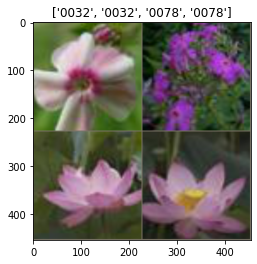

In [ ]:
# Function to show images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Retrieve 2 classes
classes_to_display = np.random.choice(num_classes, 2, replace=False)

# Retrieve 2 images for each class
images_to_display = []
for class_index in classes_to_display:
    class_indices = [i for i, x in enumerate(train_data.targets) if x == class_index]
    images_indices = np.random.choice(class_indices, 2, replace=False)
    for img_index in images_indices:
        images_to_display.append(train_data[img_index][0])

# Make a grid from batch of the selected images
out = torchvision.utils.make_grid(images_to_display, nrow=2)

# Show images
imshow(out, title=[class_names[x] for x in classes_to_display for _ in range(2)])

In [ ]:
import torchvision.models as models

# Load the pretrained ResNet50 model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer
model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))


/home/pi2018/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pi2018/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Answer:**

Above, we can see that first row has 2 images of the same class - 0032, and second row has another 2 (different) images of the same class - 0078. Futher, we have preloaded ResNet50 model and changed the final fully connected layer to number of our classes (102).

### 2.1 (b)

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up the criterion for loss calculation
criterion = torch.nn.CrossEntropyLoss()

# Set up the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Drop the learning rate by a factor of 0.1 at the 15th, 30th, and 45th epoch
step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30, 45], gamma=0.1)

# Data loader for training
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)


train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Training & validation loop
for epoch in range(60):

    # Training
    model.train()  # Set model to training mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data - training
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs)
        i, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward + optimize
        loss.backward()
        optimizer.step()

        # Statistics - loss & corrects (for acc)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.double() / len(train_data)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    # Validation
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    val_running_corrects = 0

    # Iterate over data - validation
    with torch.no_grad(): #no gradient and no updated weights
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            i, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(val_data)
    val_epoch_acc = val_running_corrects.double() / len(val_data)

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())

    print(f'Epoch {epoch+1}/{60} - Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} - Validation Loss: {val_epoch_loss:.4f} Validation Acc: {val_epoch_acc:.4f}')


    # Step the scheduler
    step_lr_scheduler.step()

print('Finished Training')

Epoch 1/60 - Train Loss: 4.6645 Train Acc: 0.0069 - Validation Loss: 4.6012 Validation Acc: 0.0127
Epoch 2/60 - Train Loss: 4.4881 Train Acc: 0.0451 - Validation Loss: 4.4762 Validation Acc: 0.0539
Epoch 3/60 - Train Loss: 4.2857 Train Acc: 0.2304 - Validation Loss: 4.3270 Validation Acc: 0.1804
Epoch 4/60 - Train Loss: 4.0742 Train Acc: 0.4706 - Validation Loss: 4.1951 Validation Acc: 0.2431
Epoch 5/60 - Train Loss: 3.8420 Train Acc: 0.6265 - Validation Loss: 4.0244 Validation Acc: 0.3294
Epoch 6/60 - Train Loss: 3.5834 Train Acc: 0.7039 - Validation Loss: 3.8134 Validation Acc: 0.4049
Epoch 7/60 - Train Loss: 3.3179 Train Acc: 0.7382 - Validation Loss: 3.5784 Validation Acc: 0.4196
Epoch 8/60 - Train Loss: 3.0383 Train Acc: 0.7647 - Validation Loss: 3.3930 Validation Acc: 0.4657
Epoch 9/60 - Train Loss: 2.7575 Train Acc: 0.7980 - Validation Loss: 3.1682 Validation Acc: 0.4882
Epoch 10/60 - Train Loss: 2.4971 Train Acc: 0.8255 - Validation Loss: 3.0049 Validation Acc: 0.5216
Epoch 11/

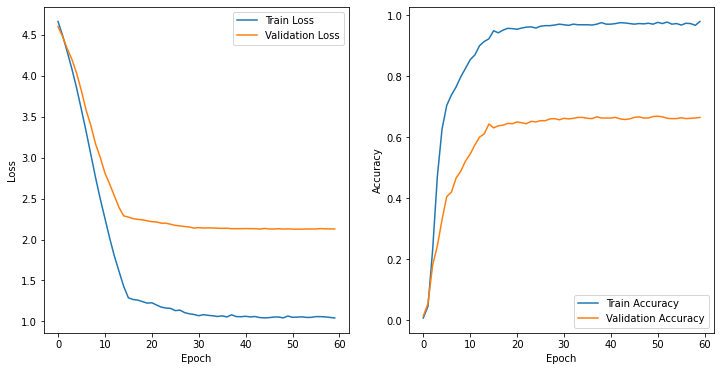

In [ ]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Answer:**

We have trained the model with 60 epochs with 3 gamma = 0.1 drops in epochs 15, 30, 45 as recommended starting with learning rate of 0.001. We can see that as epochs increase,  both training loss and validation loss lowers and both training accuracy and validation accuracy increases. However, we can firstly notice that training loss is decreasing much more than validation and similarly, training accuracy is increasing much more than validation. While it is usually expected for training set to have 'higher' accuracy since it is the one model is learning on this kind of large disparity indicates our model is most likely overfitting as it achieves almost 100% accuracy in training but only reaches up to 0.66 in validation accuracy. Finally, we can notice that training for all 60 epochs might not be worth it (the time and computational power) as after the first drop/decay in learning rate at about 15 epochs, the improvement of the model accuracy (and drop of loss) is minimal after this point.

### 2.1 (c)

In [ ]:
def train_model_with_validation(model, dataloaders, criterion, optimizer, scheduler, num_epochs=60):
    model.to(device)

    # Initialize dictionaries to hold the accuracies and losses
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train() #training

        running_loss = 0.0
        running_corrects = 0

        # Training loop
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            i, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation loop
        model.eval() #evaluation
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad(): #no updates
            for inputs, labels in dataloaders['val']:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                i, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(dataloaders['val'].dataset)
        val_epoch_acc = val_running_corrects.double() / len(dataloaders['val'].dataset)

        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc.item())

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} - Validation Loss: {val_epoch_loss:.4f} Validation Acc: {val_epoch_acc:.4f}')

        scheduler.step()

    print('Finished Training')

    return model, train_accuracies, train_losses, val_accuracies, val_losses

In [ ]:
# Define the data loader for training & validation
dataloaders = {'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)}

# Define the criterion
criterion = torch.nn.CrossEntropyLoss()

# Clone the model from above
model_001 = models.resnet50(pretrained=True)
model_001.fc = torch.nn.Linear(model_001.fc.in_features, len(class_names))

# Train the model with learning rate 0.01
optimizer_001 = optim.SGD(model_001.parameters(), lr=0.01, momentum=0.9)
scheduler_001 = lr_scheduler.MultiStepLR(optimizer_001, milestones=[15, 30, 45], gamma=0.1)

model_001, train_acc_001, train_loss_001, val_acc_001, val_loss_001 = train_model_with_validation(
    model_001, dataloaders, criterion, optimizer_001, scheduler_001, num_epochs=60)

Epoch 1/60 - Train Loss: 4.5462 Train Acc: 0.0314 - Validation Loss: 3.9517 Validation Acc: 0.1961
Epoch 2/60 - Train Loss: 3.1274 Train Acc: 0.4441 - Validation Loss: 2.4994 Validation Acc: 0.4510
Epoch 3/60 - Train Loss: 1.5779 Train Acc: 0.7343 - Validation Loss: 1.7589 Validation Acc: 0.6196
Epoch 4/60 - Train Loss: 0.6739 Train Acc: 0.9069 - Validation Loss: 1.3746 Validation Acc: 0.7098
Epoch 5/60 - Train Loss: 0.2382 Train Acc: 0.9794 - Validation Loss: 1.1915 Validation Acc: 0.7333
Epoch 6/60 - Train Loss: 0.0933 Train Acc: 1.0000 - Validation Loss: 1.0784 Validation Acc: 0.7441
Epoch 7/60 - Train Loss: 0.0407 Train Acc: 1.0000 - Validation Loss: 1.0246 Validation Acc: 0.7500
Epoch 8/60 - Train Loss: 0.0272 Train Acc: 1.0000 - Validation Loss: 0.9816 Validation Acc: 0.7588
Epoch 9/60 - Train Loss: 0.0205 Train Acc: 1.0000 - Validation Loss: 0.9610 Validation Acc: 0.7578
Epoch 10/60 - Train Loss: 0.0182 Train Acc: 1.0000 - Validation Loss: 0.9530 Validation Acc: 0.7578
Epoch 11/

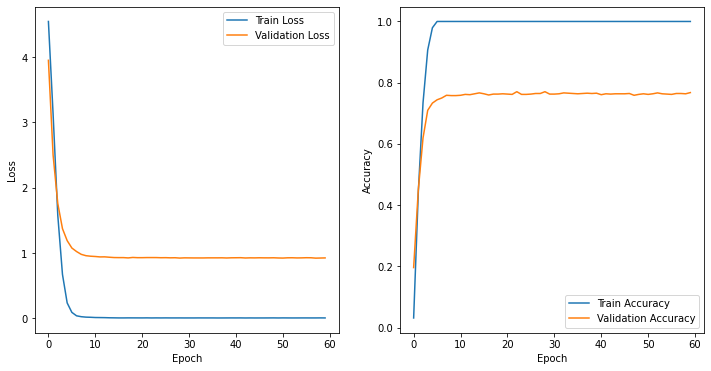

In [ ]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_001, label='Train Loss')
plt.plot(val_loss_001, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_acc_001, label='Train Accuracy')
plt.plot(val_acc_001, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Similarly as in the previous model, we have trained the model with 60 epochs with 3 gamma = 0.1 drops in epochs 15, 30, 45 as recommended but this time starting with learning rate of 0.01. Just like in previous model, we can see that as epochs increase,  both training loss and validation loss lowers and both training accuracy and validation accuracy increases. We can again notice that the training loss is decreasing much more than validation and similarly, training accuracy is increasing much more than validation. Again our training accuracy reaches about 100% accuracy while our validation accuracy is at about 0.76 at the last epoch which once again indicates our model might be overfitting.

This model that starts with higher learning rate (0.01 rather than 0.001) achieves a slightly better accuracy (0.76 vs 0.66) than our previous model and we can see that the 'drop/rise' happens much earlier at about 6/7 epochs and after that our accuracies and losses do not increse or decrease significantly, again indicating that 60 epochs might not be worth the training time as we do not see the approvement in our accuracy past that point.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model.to(device)

# Define the data loader for training & validation
dataloaders = {'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)}

# Define the criterion
criterion = torch.nn.CrossEntropyLoss()

# Clone the model again (same from above 2)
model_01 = models.resnet50(pretrained=True)
model_01.fc = torch.nn.Linear(model_01.fc.in_features, len(class_names))

# Train the model with learning rate 0.1
optimizer_01 = optim.SGD(model_01.parameters(), lr=0.1, momentum=0.9)
scheduler_01 = lr_scheduler.MultiStepLR(optimizer_01, milestones=[15, 30, 45], gamma=0.1)

model_01, train_acc_01, train_loss_01, val_acc_01, val_loss_01 = train_model_with_validation(
    model_01, dataloaders, criterion, optimizer_01, scheduler_01, num_epochs=60)

Epoch 1/60 - Train Loss: 4.8782 Train Acc: 0.0676 - Validation Loss: 112.7466 Validation Acc: 0.0127
Epoch 2/60 - Train Loss: 4.3655 Train Acc: 0.0539 - Validation Loss: 2249.1896 Validation Acc: 0.0098
Epoch 3/60 - Train Loss: 3.8297 Train Acc: 0.1108 - Validation Loss: 7.9779 Validation Acc: 0.0500
Epoch 4/60 - Train Loss: 3.3204 Train Acc: 0.1559 - Validation Loss: 4.8717 Validation Acc: 0.1186
Epoch 5/60 - Train Loss: 2.9746 Train Acc: 0.2324 - Validation Loss: 4.4217 Validation Acc: 0.1324
Epoch 6/60 - Train Loss: 2.7880 Train Acc: 0.2667 - Validation Loss: 3.5868 Validation Acc: 0.1755
Epoch 7/60 - Train Loss: 2.3767 Train Acc: 0.3490 - Validation Loss: 3.3434 Validation Acc: 0.2314
Epoch 8/60 - Train Loss: 2.1789 Train Acc: 0.3912 - Validation Loss: 3.4849 Validation Acc: 0.2314
Epoch 9/60 - Train Loss: 1.9256 Train Acc: 0.4627 - Validation Loss: 3.4551 Validation Acc: 0.2676
Epoch 10/60 - Train Loss: 1.7094 Train Acc: 0.5020 - Validation Loss: 3.1961 Validation Acc: 0.3069
Epoc

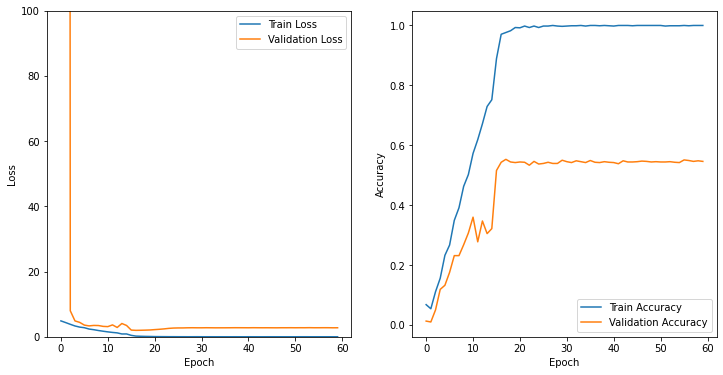

In [ ]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_01, label='Train Loss')
plt.plot(val_loss_01, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,100)
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_acc_01, label='Train Accuracy')
plt.plot(val_acc_01, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Answer:**

Note: I have limited the loss y axis to 100 to show that validation loss does not go entirely to 0, but to around 2.77 which is not that different from the end validation loss in our first model with learning rate of 0.001 when it was about 2.1.

In these graphs we can notice that they slightly differ from the previous two. Focusing on the training and validation loss, there was a very high peak in validation loss in the first two epochs of our model which could be the result of overly large learning rate (0.1). Further, looking at the graph of accuracies, we can notice that it is not as 'smooth' increase (especially for validation accuracy) as it was in the previous 2 graphs abd we can see a slight dip at arund 15 epochs which could be due to our scheduled decay. Just like with previous two models we can see that the model is most likely overfitting since training accuracy goes all the way up to 100% while validation accuracy is only around 0.55 at the end of the training. Finally just like in previous 2 diagrams, we can notice that training for all 60 epochs might not be worth it as the accuracy does not rise (or significantly change) after about 20 epochs.

**Model Comparison:**

Comparing all 3 models we can notice that the 2. model with learning rate at 0.01 (middle) achieves higest validation accuracy of 0.76 which is quite a bit higher than in other two models (0.66 for lr = 0.001 and 0.55 for lr = 0.1). Due to this we can conclude that the 2nd model preforms best on our target dataset, followed by the first one (lr = 0.001) with validation accuracy of 0.66 and the last one (lr = 0.1) preforms the worse with validation accuracy of 0.55. Thus, we should chose the second model with learning rate at 0.01 since it has significantly highest accuracy and same training time as others, but we might consider training it with much less epochs (e.g. 40) since it reached it's 'peak' in accuracy relatively quickly so there might not be a need for additional epochs.

## 2.2

### 2.2 (a)

In [ ]:
# Function to train the models so we don't have to write it 4 times
def train_last_layer(model, dataloaders, criterion, optimizer, scheduler, num_epochs=60):
    model.to(device)

    # Initialize dictionaries to hold the accuracies and losses for both training and validation
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train() # Training stage

        running_loss = 0.0
        running_corrects = 0

        # Training loop
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Set requires_grad=False for all parameters except the last layer
            # 'Freezes' other layers but last
            for param in model.parameters():
                param.requires_grad = False
            for param in model.fc.parameters():
                param.requires_grad = True

            outputs = model(inputs)
            i, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        print(f'Epoch {epoch + 1}/{num_epochs} - Training Loss: {epoch_loss:.4f} Training Acc: {epoch_acc:.4f}')


        # Validation loop
        model.eval() # Evaluation stage
        val_running_loss = 0.0
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                i, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(dataloaders['val'].dataset)
        val_epoch_acc = val_running_corrects.double() / len(dataloaders['val'].dataset)

        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc.item())

        print(f'Epoch {epoch + 1}/{num_epochs} - Validation Loss: {val_epoch_loss:.4f} Validation Acc: {val_epoch_acc:.4f}')

        scheduler.step()

    print('Finished Training')

    return train_accuracies, train_losses, val_accuracies, val_losses

In [ ]:
import copy # to be able to copy the same model for all 4 runs as we are only changing the learning rates

# Clone the model from part 1 (fine-tuned model)
model_last_layer = models.resnet50(pretrained=True)
model_last_layer.fc = torch.nn.Linear(model_last_layer.fc.in_features, len(class_names))

# Define the data loaders for training and validation
dataloaders = {'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)}

# Define the criterion - loss
criterion = torch.nn.CrossEntropyLoss()

# Define the list of learning rates
learning_rates = [1.0, 0.1, 0.01, 0.001]

# Save results for different learning rates
results = {}

# Train only the last layer (while others are frozen) at different learning rates
for lr in learning_rates:
    # Clone the model to start with the same initial weights
    model = copy.deepcopy(model_last_layer)

    # Initialize optimizer and scheduler with the specified learning rate like in part 1
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30, 45], gamma=0.1)

    print(f"Training with learning rate: {lr}") # to keep track where we are
    train_acc, train_loss, val_acc, val_loss = train_last_layer(
        model, dataloaders, criterion, optimizer, scheduler, num_epochs=60)

    results[lr] = { # save the results so we can plot them
        'train_acc': train_acc,
        'train_loss': train_loss,
        'val_acc': val_acc,
        'val_loss': val_loss
    }

Training with learning rate: 1.0
Epoch 1/60 - Training Loss: 97.8696 Training Acc: 0.0598
Epoch 1/60 - Validation Loss: 275.4441 Validation Acc: 0.2039
Epoch 2/60 - Training Loss: 386.6294 Training Acc: 0.2627
Epoch 2/60 - Validation Loss: 394.2994 Validation Acc: 0.2294
Epoch 3/60 - Training Loss: 312.5165 Training Acc: 0.4078
Epoch 3/60 - Validation Loss: 242.8357 Validation Acc: 0.3167
Epoch 4/60 - Training Loss: 147.1715 Training Acc: 0.5225
Epoch 4/60 - Validation Loss: 113.6219 Validation Acc: 0.3137
Epoch 5/60 - Training Loss: 60.9750 Training Acc: 0.6245
Epoch 5/60 - Validation Loss: 58.9325 Validation Acc: 0.3892
Epoch 6/60 - Training Loss: 20.7448 Training Acc: 0.7627
Epoch 6/60 - Validation Loss: 34.7958 Validation Acc: 0.4755
Epoch 7/60 - Training Loss: 7.5811 Training Acc: 0.8402
Epoch 7/60 - Validation Loss: 28.1413 Validation Acc: 0.4755
Epoch 8/60 - Training Loss: 4.6042 Training Acc: 0.8873
Epoch 8/60 - Validation Loss: 27.5666 Validation Acc: 0.4667
Epoch 9/60 - Train

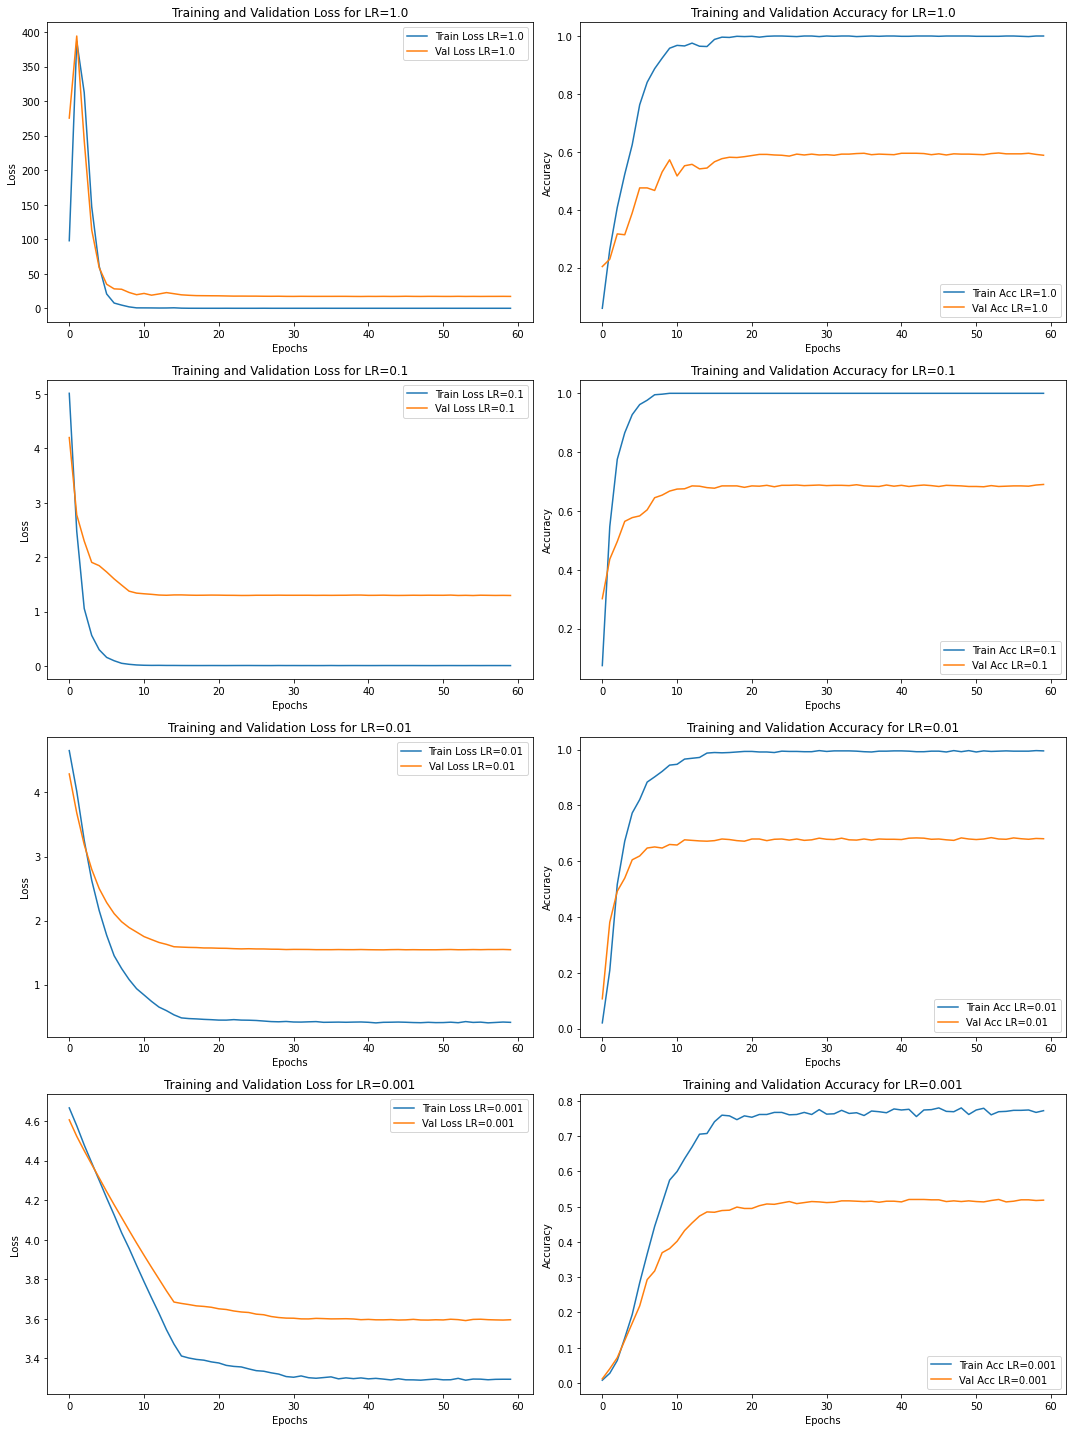

In [ ]:
# Figure w 4 rows (for each learning rate) and 2 columns (for loss and accuracy)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

# Go through each learning rate and its corresponding data
for i, (lr, data) in enumerate(results.items()):
    # Plot train and validation loss on the left column (i, 0)
    axes[i, 0].plot(data['train_loss'], label=f'Train Loss LR={lr}')
    axes[i, 0].plot(data['val_loss'], label=f'Val Loss LR={lr}')
    axes[i, 0].set_title(f'Training and Validation Loss for LR={lr}')
    axes[i, 0].set_xlabel('Epochs')
    axes[i, 0].set_ylabel('Loss')
    axes[i, 0].legend()

    # Plot train and validation accuracy on the right column (i, 1)
    axes[i, 1].plot(data['train_acc'], label=f'Train Acc LR={lr}')
    axes[i, 1].plot(data['val_acc'], label=f'Val Acc LR={lr}')
    axes[i, 1].set_title(f'Training and Validation Accuracy for LR={lr}')
    axes[i, 1].set_xlabel('Epochs')
    axes[i, 1].set_ylabel('Accuracy')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
print(f"Model with fixed features and Learning Rate of 1.0 - Train Loss: {results[1.0]['train_loss'][-1]:.4f}, Train Acc: {results[1.0]['train_acc'][-1]:.4f}, Validation Loss: {results[1.0]['val_loss'][-1]:.4f}, Validation Acc: {results[1.0]['val_acc'][-1]:.4f}\n")
print(f"Model with fixed features and Learning Rate of 0.1 - Train Loss: {results[0.1]['train_loss'][-1]:.4f}, Train Acc: {results[0.1]['train_acc'][-1]:.4f}, Validation Loss: {results[0.1]['val_loss'][-1]:.4f}, Validation Acc: {results[0.1]['val_acc'][-1]:.4f}\n")
print(f"Model with fixed features and Learning Rate of 0.01 - Train Loss: {results[0.01]['train_loss'][-1]:.4f}, Train Acc: {results[0.01]['train_acc'][-1]:.4f}, Validation Loss: {results[0.01]['val_loss'][-1]:.4f}, Validation Acc: {results[0.01]['val_acc'][-1]:.4f}\n")
print(f"Model with fixed features and Learning Rate of 0.001 - Train Loss: {results[0.001]['train_loss'][-1]:.4f}, Train Acc: {results[0.001]['train_acc'][-1]:.4f}, Validation Loss: {results[0.001]['val_loss'][-1]:.4f}, Validation Acc: {results[0.001]['val_acc'][-1]:.4f}\n")

Model with fixed features and Learning Rate of 1.0 - Train Loss: 0.0000, Train Acc: 1.0000, Validation Loss: 17.1981, Validation Acc: 0.5882

Model with fixed features and Learning Rate of 0.1 - Train Loss: 0.0083, Train Acc: 1.0000, Validation Loss: 1.2970, Validation Acc: 0.6902

Model with fixed features and Learning Rate of 0.01 - Train Loss: 0.4106, Train Acc: 0.9951, Validation Loss: 1.5449, Validation Acc: 0.6804

Model with fixed features and Learning Rate of 0.001 - Train Loss: 3.2948, Train Acc: 0.7725, Validation Loss: 3.5958, Validation Acc: 0.5186



**Answer:**
Looking at the graphs and the print out of losses and accuracies above for the last epochs of training we can notice that the accuracy is the highest for middle two learning rates, 0.1 and 0.01 when it is in high 60 and it is lower for other to larger and smaller learning rates. More precisely, the 2nd model with learning rate 0.1 has highest validation accuracy at 0.69 and lowest validation loss at 1.297 followed by 3rd model with learning rate of 0.01 and slightly lower validation accuracy of 0.68. Next one is the first model with learning rate of 1.0 and significantly lower validation accuracy of 0.59 followed by the 4th model with learning rate of 0.001 with lowest accuracy of 0.52.


Looking at the diagrams we can see that they all follow the similar structure just like those in part 1 where the loss falls and accuracy rises significanly after first few epochs (15 - 20 epoch max) and after that it is relatively constant (doesn't change much) until the end of the modelling. Further, just like in part 1 we can notice that the models are all most likely overfitting since their trainig accuracies are much much higer than the validation ones.

Since all the models have same training times we should go with model 2 (lr = 0.1) since it achieves lowest loss and highest validation accuracy compared to all other models.

### 2.2 (b)

In [ ]:
# Model results from part 1
print(f"Finetuned model with initial Learning Rate of 0.001 - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Acc: {val_accuracies[-1]:.4f}\n")
print(f"Finetuned model with initial Learning Rate of 0.01 - Train Loss: {train_loss_001[-1]:.4f}, Train Acc: {train_acc_001[-1]:.4f}, Validation Loss: {val_loss_001[-1]:.4f}, Validation Acc: {val_acc_001[-1]:.4f}\n")
print(f"Finetuned model with initial Learning Rate of 0.1 - Train Loss: {train_loss_01[-1]:.4f}, Train Acc: {train_acc_01[-1]:.4f}, Validation Loss: {val_loss_01[-1]:.4f}, Validation Acc: {val_acc_01[-1]:.4f}\n")

Finetuned model with initial Learning Rate of 0.001 - Train Loss: 1.0422, Train Acc: 0.9794, Validation Loss: 2.1293, Validation Acc: 0.6647

Model with fixed features and Learning Rate of 0.01 - Train Loss: 0.0081, Train Acc: 1.0000, Validation Loss: 0.9269, Validation Acc: 0.7676

Model with fixed features and Learning Rate of 0.1 - Train Loss: 0.0128, Train Acc: 1.0000, Validation Loss: 2.7715, Validation Acc: 0.5461



In [ ]:
# Model results from part 2
print(f"Model with fixed features and Learning Rate of 1.0 - Train Loss: {results[1.0]['train_loss'][-1]:.4f}, Train Acc: {results[1.0]['train_acc'][-1]:.4f}, Validation Loss: {results[1.0]['val_loss'][-1]:.4f}, Validation Acc: {results[1.0]['val_acc'][-1]:.4f}\n")
print(f"Model with fixed features and Learning Rate of 0.1 - Train Loss: {results[0.1]['train_loss'][-1]:.4f}, Train Acc: {results[0.1]['train_acc'][-1]:.4f}, Validation Loss: {results[0.1]['val_loss'][-1]:.4f}, Validation Acc: {results[0.1]['val_acc'][-1]:.4f}\n")
print(f"Model with fixed features and Learning Rate of 0.01 - Train Loss: {results[0.01]['train_loss'][-1]:.4f}, Train Acc: {results[0.01]['train_acc'][-1]:.4f}, Validation Loss: {results[0.01]['val_loss'][-1]:.4f}, Validation Acc: {results[0.01]['val_acc'][-1]:.4f}\n")
print(f"Model with fixed features and Learning Rate of 0.001 - Train Loss: {results[0.001]['train_loss'][-1]:.4f}, Train Acc: {results[0.001]['train_acc'][-1]:.4f}, Validation Loss: {results[0.001]['val_loss'][-1]:.4f}, Validation Acc: {results[0.001]['val_acc'][-1]:.4f}\n")

Model with fixed features and Learning Rate of 1.0 - Train Loss: 0.0000, Train Acc: 1.0000, Validation Loss: 17.1981, Validation Acc: 0.5882

Model with fixed features and Learning Rate of 0.1 - Train Loss: 0.0083, Train Acc: 1.0000, Validation Loss: 1.2970, Validation Acc: 0.6902

Model with fixed features and Learning Rate of 0.01 - Train Loss: 0.4106, Train Acc: 0.9951, Validation Loss: 1.5449, Validation Acc: 0.6804

Model with fixed features and Learning Rate of 0.001 - Train Loss: 3.2948, Train Acc: 0.7725, Validation Loss: 3.5958, Validation Acc: 0.5186



**Answer:**

Above we have all the statistics for all 7 different models we built in this task. As previously mentoned in first approach, without freezing the layers, our second model, with learning rate 0.01 preformed the best with validation accuracy of 0.7676 and validation loss of 0.9269. Since all models in first part took same time to run (same models with different learning rates) we should choose this model since it preformed the best.


In the second approach we froze all the layers but last and so that no inner layers are updated in the backward pass. Over all this led to the highest accuracy of 0.6902 for the second model with learning rate of 0.1. This indicates this is the best of our models for this approach and thus we should choose it amongs others for the same approach.

When deciding which method to choose there are multiple things we should consider. As expected (not 100% expected but is often the case) second approach, freezing the layers resulted in lower max validation accuracy as it was only updating weights in the last layer instead of all. This did however lead to significantly shorter training time. Thus, as is often the case, we need to decide if the model from first approach, with higher accuracy of 0.7676 (lr = 0.01) that trained slowly (and is thus more computationally expensive) is worth it in our use case compared to the the quicker (and with that cheaper) model from second approach (freezing layers) that only achieved accuracy of 0.6902 (lr = 0.1). I would argue that if we have resources to do so we should choose the first model (no layer freezing, lr = 0.01) as using the second one does not reduce overfitting by freezing layers and its validation accuracy is significantly lower compared to the first one (no frozen layers).

One thing that is also worth noting is that we should consider if there are different approaches such as dropout that we could introduce to try and reduce overfitting in our training as it is preminent in all of our models.
